In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px

In [2]:
# Step 1: Load the dataset
df = pd.read_csv('data.csv')  # Replace with your actual CSV file path

In [3]:
# Step 2: Convert 'Date' column to datetime format and handle any errors in conversion
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [4]:
# Step 3: Remove rows with invalid or missing 'Date' values
df = df.dropna(subset=['Date'])


In [5]:
# Step 4: Set 'Date' as the index and ensure there are no duplicate dates
df.set_index('Date', inplace=True)
df = df[~df.index.duplicated(keep='last')]

In [6]:
# Step 5: Sort the DataFrame by Date (ascending order)
df.sort_index(inplace=True)

In [7]:
# Step 6: Forward fill missing values in the dataset (e.g., for missing stock prices)
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_15174/2671915263.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [8]:
# Data Overview
print("Data Overview:")
print(df.head())

Data Overview:
            Open  High  Low  Close  Volume Symbol
Date                                             
2023-01-01   100   110   90    105  100000   AAPL
2023-01-02   105   115  100    110  150000   AAPL
2023-01-03   110   120  105    115  200000   AAPL
2023-01-04   115   125  110    120  250000   AAPL
2023-01-05   120   130  115    125  300000   AAPL


In [9]:
# Step 7: Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
             Open        High         Low       Close         Volume
count    5.000000    5.000000    5.000000    5.000000       5.000000
mean   110.000000  120.000000  104.000000  115.000000  200000.000000
std      7.905694    7.905694    9.617692    7.905694   79056.941504
min    100.000000  110.000000   90.000000  105.000000  100000.000000
25%    105.000000  115.000000  100.000000  110.000000  150000.000000
50%    110.000000  120.000000  105.000000  115.000000  200000.000000
75%    115.000000  125.000000  110.000000  120.000000  250000.000000
max    120.000000  130.000000  115.000000  125.000000  300000.000000


In [10]:
# Step 8: Calculate daily returns (percentage change from previous day)
df['Daily Return'] = df['Close'].pct_change()

In [11]:
# Step 9: Calculate MACD (Moving Average Convergence Divergence) and Signal Line
short_ema = df['Close'].ewm(span=12, adjust=False).mean()
long_ema = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [12]:
# Step 10: Calculate Bollinger Bands (upper and lower bands for volatility)
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['Upper Band'] = rolling_mean + (rolling_std * 2)
df['Lower Band'] = rolling_mean - (rolling_std * 2)

In [13]:
# Step 11: Calculate RSI (Relative Strength Index)
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [14]:
# Step 12: Calculate Exponential Moving Average (EMA) for 50 and 200 periods
df['50-day EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
df['200-day EMA'] = df['Close'].ewm(span=200, adjust=False).mean()

In [15]:
# Step 13: Portfolio Analysis (Sharpe Ratio)
returns = df['Daily Return'].mean() * 252  # Annualized return
portfolio_risk = df['Daily Return'].std() * np.sqrt(252)  # Annualized risk (volatility)
sharpe_ratio = returns / portfolio_risk  # Sharpe ratio: return / risk
print(f"\nPortfolio Sharpe Ratio: {sharpe_ratio}")


Portfolio Sharpe Ratio: 276.01149944814716


In [16]:
# Step 14: ARIMA Forecasting (predicting future stock prices)
model = ARIMA(df['Close'], order=(5, 1, 0))  # ARIMA model (example order, adjust based on ACF/PACF)
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)  # Forecast the next 10 days
print("\nARIMA Forecasting (Next 10 Days):")
print(forecast)

/home/misagh/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/misagh/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/misagh/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/misagh/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



ARIMA Forecasting (Next 10 Days):
2023-01-06    129.999996
2023-01-07    134.999995
2023-01-08    139.999988
2023-01-09    144.999986
2023-01-10    149.999976
2023-01-11    154.999973
2023-01-12    159.999960
2023-01-13    164.999955
2023-01-14    169.999940
2023-01-15    174.999933
Freq: D, Name: predicted_mean, dtype: float64


/home/misagh/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Step 15: Monte Carlo Simulation for Stock Prices
num_simulations = 1000  # Number of simulations
num_days = 252  # 1 year of trading days
simulated_prices = np.zeros((num_simulations, num_days))

In [18]:
# Simulate price movements based on daily returns
for i in range(num_simulations):
    daily_returns = np.random.normal(df['Daily Return'].mean(), df['Daily Return'].std(), num_days)
    price_series = df['Close'].iloc[-1] * (1 + daily_returns).cumprod()  # Apply daily returns to initial price
    simulated_prices[i] = price_series

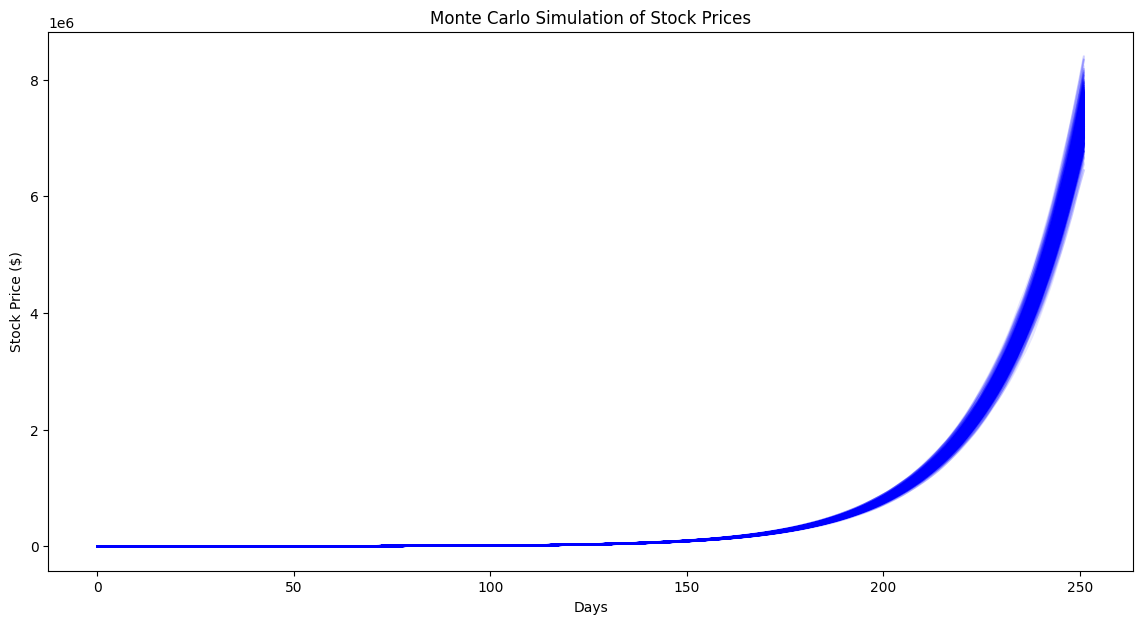

In [19]:
# Step 16: Visualize Monte Carlo Simulation results
plt.figure(figsize=(14, 7))
plt.plot(simulated_prices.T, color='blue', alpha=0.1)
plt.title("Monte Carlo Simulation of Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price ($)")
plt.show()

In [20]:
# Step 17: Backtesting a Moving Average Crossover Strategy
df['7-day MA'] = df['Close'].rolling(window=7).mean()
df['30-day MA'] = df['Close'].rolling(window=30).mean()

In [21]:
# Generate buy/sell signals based on the crossover strategy
df['Signal'] = 0
df['Signal'][df['7-day MA'] > df['30-day MA']] = 1  # Buy signal: 7-day MA crosses above 30-day MA
df['Signal'][df['7-day MA'] < df['30-day MA']] = -1  # Sell signal: 7-day MA crosses below 30-day MA

/tmp/ipykernel_15174/2782414317.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][df['7-day MA'] > df['30-day MA']] = 1  # Buy signal: 7-day MA crosses above 30-day MA
/tmp/ipykernel_15174/2782414317.py:3: SettingWithCopyWarni

In [22]:
# Calculate strategy returns
df['Strategy Return'] = df['Daily Return'] * df['Signal'].shift(1)  # Lagging signal by 1 day for correct backtest
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod() - 1  # Cumulative return of the strategy


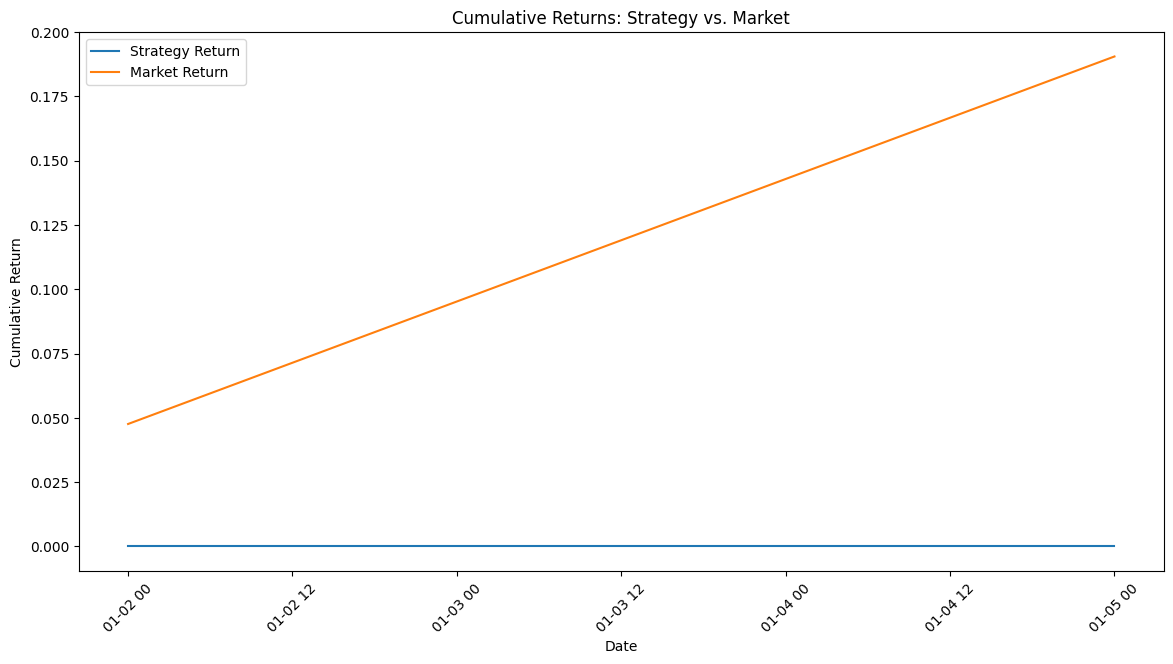

In [23]:
# Step 18: Visualize Cumulative Strategy Return vs. Market Return
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Cumulative Strategy Return'], label='Strategy Return')
sns.lineplot(x=df.index, y=(1 + df['Daily Return']).cumprod() - 1, label='Market Return')
plt.title("Cumulative Returns: Strategy vs. Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [24]:
# Step 19: Plot Technical Indicators (RSI and MACD)
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [25]:
# Step 20: Interactive Visualization with Plotly for Closing Price and Volume
fig1 = px.line(df, x=df.index, y='Close', title='Stock Prices Over Time', color='Symbol')
fig1.show()

fig2 = px.line(df, x=df.index, y='Volume', title='Trading Volume Over Time', color='Symbol')
fig2.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Step 21: Save the analyzed data to a new CSV file
df.to_csv("analyzed_stock_data.csv")

In [ ]:
print("\nAnalysis Complete. The data has been saved as 'analyzed_stock_data.csv'.")